# SysGen Functional Gene Embedding Project

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [3]:
sigmas, metadata, gene_lists = munge_sigma('../data/HDL_cholesterol.genes.raw')

In [4]:
# create covariates from pops
covariates = []
for i in range(0, 22):
    #print(i)
    covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                   index = gene_lists[i],
                                   columns = ['genesize',
                                              'log_genesize',
                                              'genedensity',
                                              'log_genedensity',
                                              'inverse_mac',
                                              'log_inverse_mac'])
                      )
covariates = pd.concat(covariates)

In [5]:
covariates

,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
ENSG00000187634,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
ENSG00000188976,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
ENSG00000187961,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
ENSG00000187583,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
ENSG00000187642,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...
ENSG00000008735,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
ENSG00000100299,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
ENSG00000251322,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
ENSG00000100312,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Load Embeddings

In [6]:
# emb_path = '../data/Omics_d256.tsv'
emb_path = '../data/TabulaSapiens_d128.tsv'

In [7]:
# load embedding
emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
emb

,FACT_EMB_0,FACT_EMB_1,FACT_EMB_2,FACT_EMB_3,FACT_EMB_4,FACT_EMB_5,FACT_EMB_6,FACT_EMB_7,FACT_EMB_8,FACT_EMB_9,...,FACT_EMB_118,FACT_EMB_119,FACT_EMB_120,FACT_EMB_121,FACT_EMB_122,FACT_EMB_123,FACT_EMB_124,FACT_EMB_125,FACT_EMB_126,FACT_EMB_127
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000121410,0.397898,-0.619606,0.197080,0.206075,0.487327,-0.130210,0.694295,0.066933,-0.002644,0.019016,...,-0.586537,-0.189327,-0.281588,0.794226,0.450134,-0.056704,0.189903,0.090775,-0.312061,0.013795
ENSG00000148584,0.019631,0.105285,-0.164675,-0.366149,0.041693,-0.605392,0.039391,-0.081647,-0.680132,0.417165,...,-0.303413,0.135788,-0.749402,0.081660,0.071958,-0.663785,0.006457,0.008557,-0.572154,-0.091617
ENSG00000175899,0.206388,-0.434583,0.135077,0.136972,0.349690,-0.053918,0.380534,-0.405700,0.025218,-0.166301,...,0.444234,-0.126186,-0.215977,-0.316875,-0.029652,-0.274389,0.368234,0.035494,-0.097415,0.203788
ENSG00000166535,0.361388,-0.309084,0.044041,-0.345444,0.249813,-0.171147,0.622800,0.097036,-0.022604,0.158737,...,-0.357637,0.251788,-0.656097,0.422899,0.086865,-0.457098,0.814789,0.108453,-0.549387,-0.137657
ENSG00000184389,-0.084553,-0.079659,0.521774,-0.344599,0.608893,-0.269933,0.134993,0.208777,-0.292158,0.041449,...,-0.331455,-0.152695,-0.602804,0.640094,0.303997,-0.311243,0.588258,0.301015,-0.071225,-0.188245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000203995,-0.192088,-0.527726,0.564879,0.334749,0.164973,-0.011938,-0.005079,0.163140,-0.776939,0.165401,...,-0.316673,0.324286,-0.619148,0.269568,-0.051767,-0.273430,0.619877,0.170769,-0.324416,-0.575503
ENSG00000162378,0.389417,-0.302356,0.226134,0.231177,0.633049,-0.378878,0.270924,-0.321942,-0.136347,0.192838,...,-0.366426,0.143965,-0.476664,0.549909,0.454654,-0.310580,0.454901,0.000682,0.061252,-0.540969
ENSG00000159840,0.343140,-0.140446,0.471138,0.054814,0.631070,0.075271,0.560676,-0.242739,-0.427519,0.212996,...,-0.346511,0.169067,-0.148972,0.167146,0.636596,-0.570514,0.616379,0.264107,-0.240854,-0.424334


### Load GWAS MAGMA Scores

In [8]:
magma = pd.read_csv('../data/HDL_cholesterol.genes.out', delim_whitespace=True)
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050
...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472


### Merge Data

In [9]:
magma = magma.merge(covariates, left_on = "GENE", right_index = True)

In [10]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048


### Project Y to LY

In [11]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [20]:
Ls = compute_Ls(sigmas, magma.ZSTAT)

def project_Y(Ls, magma_Z):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

magma = magma.merge(project_Y(Ls, magma))

In [13]:
magma

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,log_genesize,genedensity,log_genedensity,inverse_mac,log_inverse_mac,LY
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,3.044522,0.230769,-1.466337,0.013156,-4.330878,0.999534
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,2.397895,0.166667,-1.791759,0.019236,-3.950951,1.551349
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,1.945910,0.189189,-1.665008,0.016599,-4.098390,1.148646
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,2.944439,0.387755,-0.947381,0.011969,-4.425457,0.708156
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,1.945910,0.250000,-1.386294,0.006525,-5.032071,1.854531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17968,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,2.639057,0.212121,-1.550597,0.007717,-4.864268,0.512377
17969,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,2.484907,0.333333,-1.098612,0.008163,-4.808111,1.098611
17970,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,3.555348,0.207101,-1.574551,0.006002,-5.115722,0.082490
17971,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,2.302585,0.277778,-1.280934,0.005423,-5.217048,0.569190


### Merge Data

In [21]:
# merge with embedding
dt = magma.merge(emb, left_on = "GENE", right_on = "gene_id")

## Regression

Split by Chromosomes.

In [25]:
df = []

# Covariates 
print("Covariates only:")
for chrom in range(1,23):
    reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
    
    # Null model (covariates only)
    mod_null = reg_null.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_null = mod_null.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb.columns.to_list(), axis=1),
    )
    
    # Full model
    mod_full = reg_full.fit(
        dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        dt.query("CHR != @chrom")['LY']
    )
    pred_full = mod_full.predict(
        dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
    )

    df_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
    df_chrom['pred_LY_null'] = pred_null
    df_chrom['pred_LY'] = pred_full

    df.append(df_chrom)
    print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY_null)[0]**2}")
    print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(df_chrom.LY, df_chrom.pred_LY)[0]**2}")

print()

df = pd.concat(df)
df = df.merge(project_Y_back(Ls, df))

print(f"Overall R2 (null): {scipy.stats.pearsonr(df.ZSTAT, df.pred_null)[0]**2}")
print(f"Overall R2: {scipy.stats.pearsonr(df.ZSTAT, df.pred)[0]**2}")

Covariates only:
Chrom 1: R2 (null): 0.05259905953611336
Chrom 1: R2: 0.05099379242251353
Chrom 2: R2 (null): 0.10089757793573888
Chrom 2: R2: 0.08586852320402485
Chrom 3: R2 (null): 0.056792403980253425
Chrom 3: R2: 0.04631388404033613
Chrom 4: R2 (null): 0.051594499627489104
Chrom 4: R2: 0.034853147512094285
Chrom 5: R2 (null): 0.08649636018082153
Chrom 5: R2: 0.07185389367014995
Chrom 6: R2 (null): 0.03008567609764833
Chrom 6: R2: 0.023484498789707174
Chrom 7: R2 (null): 0.03535141383246707
Chrom 7: R2: 0.03672946090522651
Chrom 8: R2 (null): 0.06183222583181282
Chrom 8: R2: 0.06489075155608892
Chrom 9: R2 (null): 0.052818420133395105
Chrom 9: R2: 0.0507536503645008
Chrom 10: R2 (null): 0.05948925358188757
Chrom 10: R2: 0.048830403901810204
Chrom 11: R2 (null): 0.03680654067735557
Chrom 11: R2: 0.03206011359320616
Chrom 12: R2 (null): 0.029340016533729522
Chrom 12: R2: 0.029728877015914167
Chrom 13: R2 (null): 0.07216138173419942
Chrom 13: R2: 0.061498465131198686
Chrom 14: R2 (null

In [26]:
df

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,LY,pred_LY_null,pred_LY,pred_null,pred
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,0.999534,0.765504,0.830610,1.450770,1.574158
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,1.551349,0.610408,0.607078,1.275502,1.280635
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,1.148646,0.590818,0.657390,1.515472,1.653283
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,0.708156,0.806647,0.833567,1.836528,1.907107
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,1.854531,0.646113,0.743224,1.532222,1.730897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17318,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,0.512377,0.695195,0.811503,1.968488,2.166897
17319,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,1.098611,0.801030,0.753512,2.361941,2.298872
17320,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,0.082490,0.819246,0.823388,2.132070,2.145736
17321,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,0.569190,0.744075,0.679209,1.815079,1.694380


In [27]:
print("Per chrom R2 (full):")

for i in range(1, 23):
    df_tmp = df.query("CHR == @i")

    print(scipy.stats.pearsonr(df_tmp.ZSTAT, df_tmp.pred)[0]**2)

# df.to_csv(snakemake.output.pred, sep = '\t')

Per chrom R2 (full):
0.05642746034701697
0.04824792656957603
0.14223567227864434
0.04004781987653469
0.05711330849919376
0.25297903089228346
0.02731632759632501
0.04942916953445188
0.06442779165741842
0.03232340966322793
0.08484024415185047
0.05973089800490419
0.036275629004701083
0.0653651178678568
0.08956491368166301
0.12794609062897966
0.043827035636996636
0.030871999961441906
0.022261051954432787
0.19958196218960647
0.20985833164114387
0.07382793734289456


In [28]:
#scatter plot (of the predicted vs. the true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

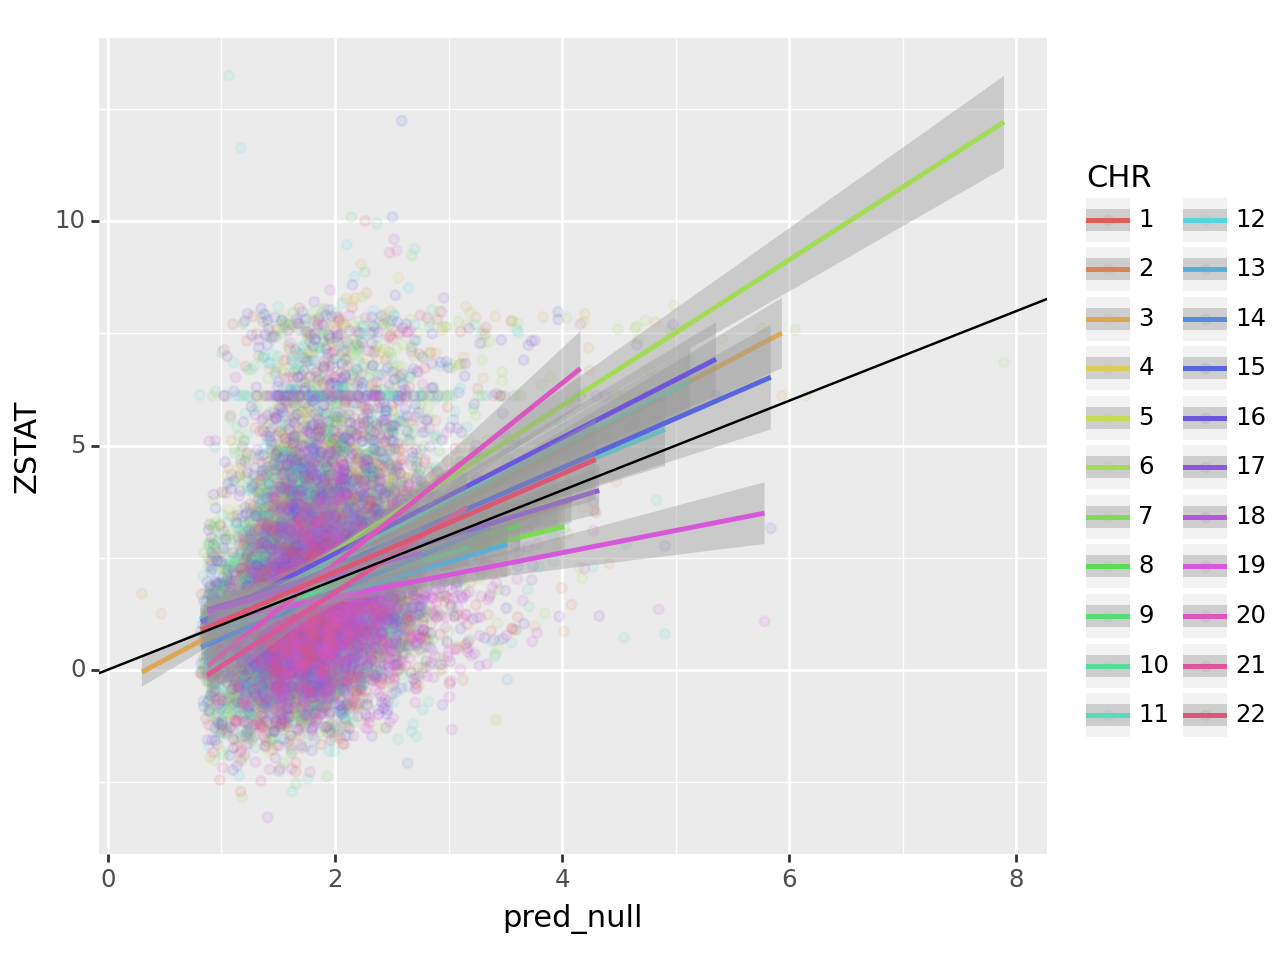

<Figure Size: (640 x 480)>

In [31]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = "CHR", smooth=True)

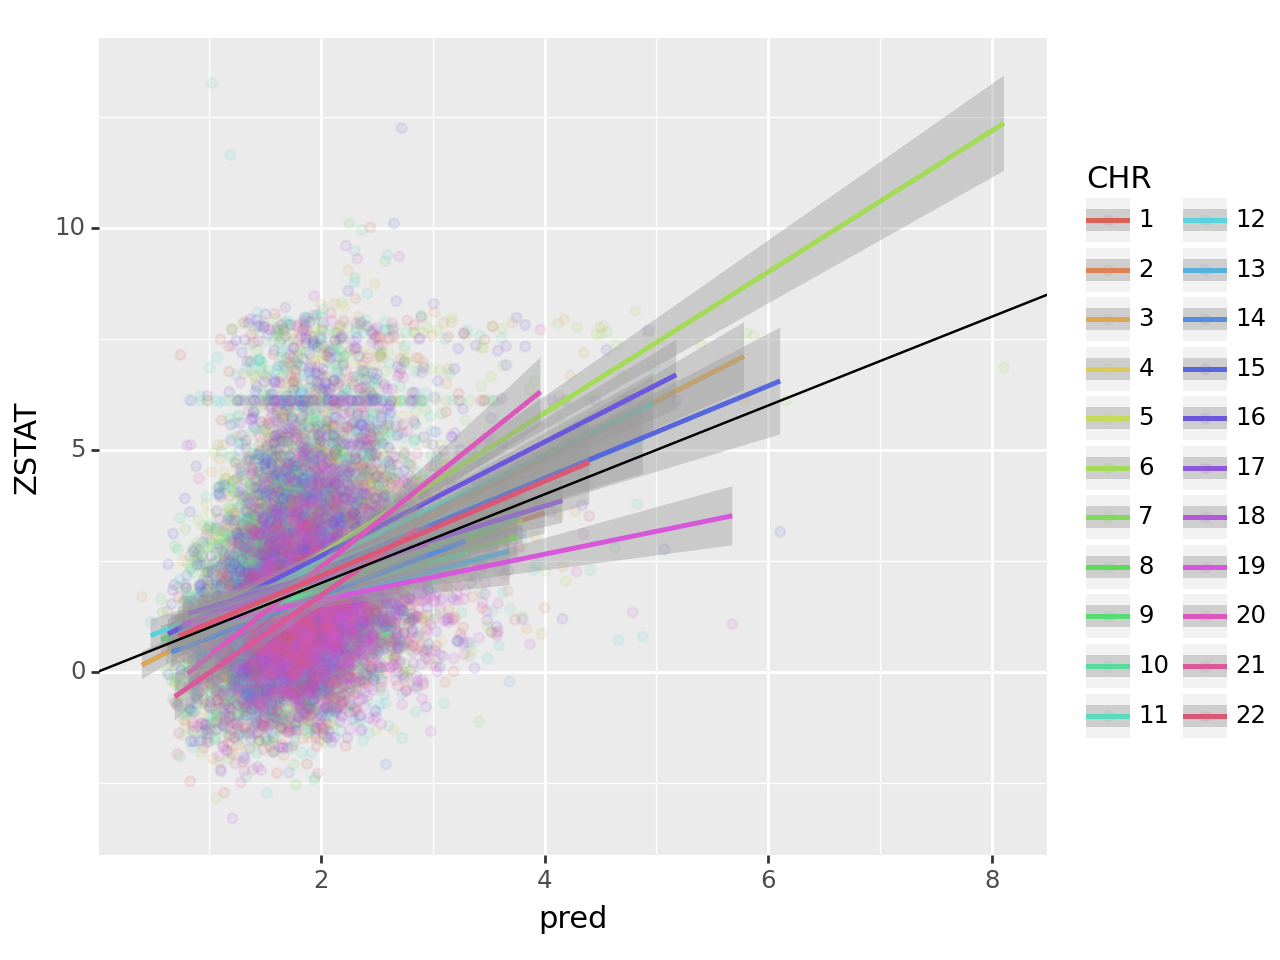

<Figure Size: (640 x 480)>

In [32]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = "CHR", smooth=True)

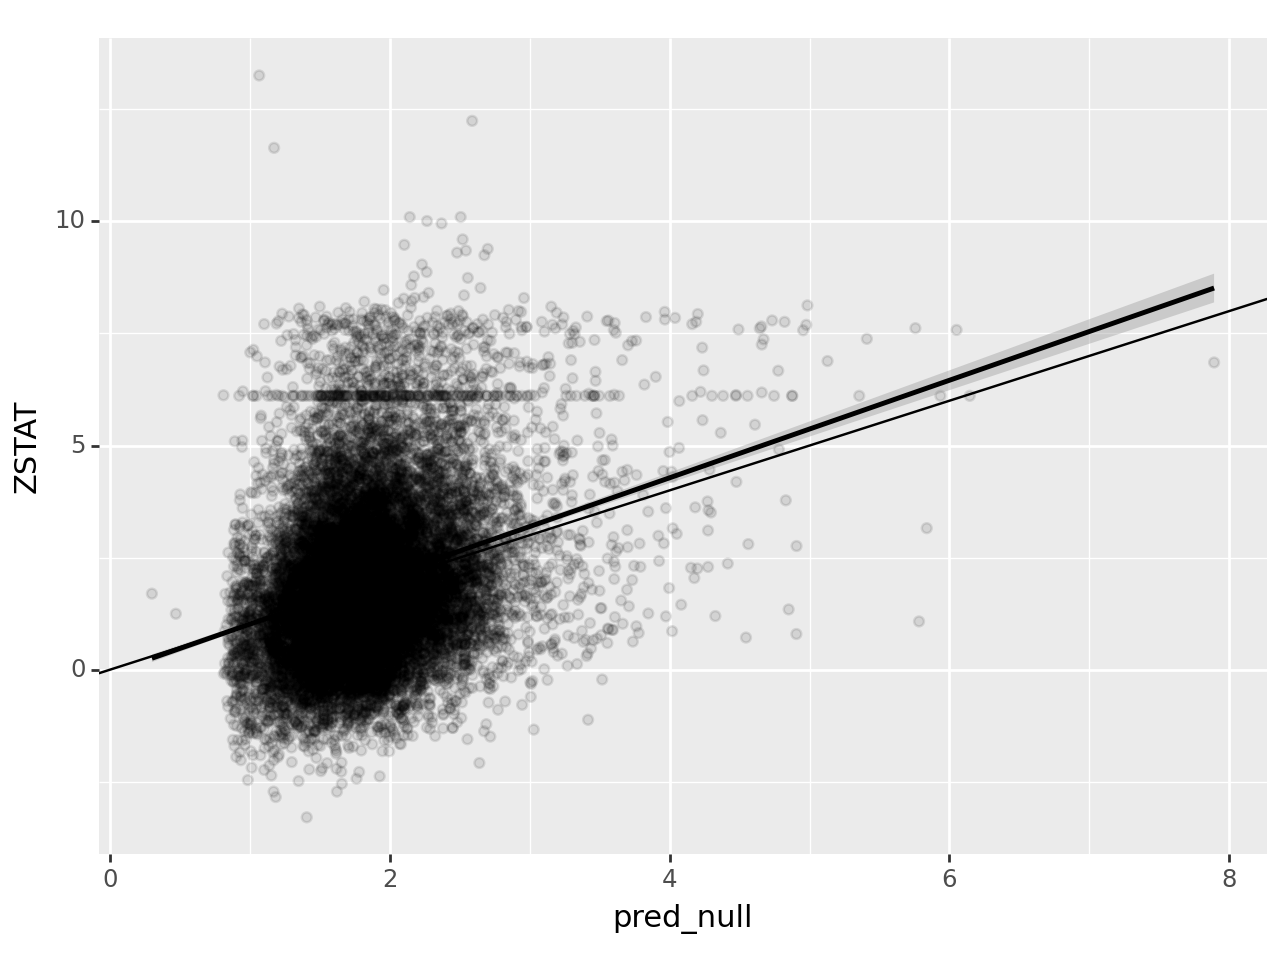

<Figure Size: (640 x 480)>

In [33]:
scatter(df, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = None, smooth=True)

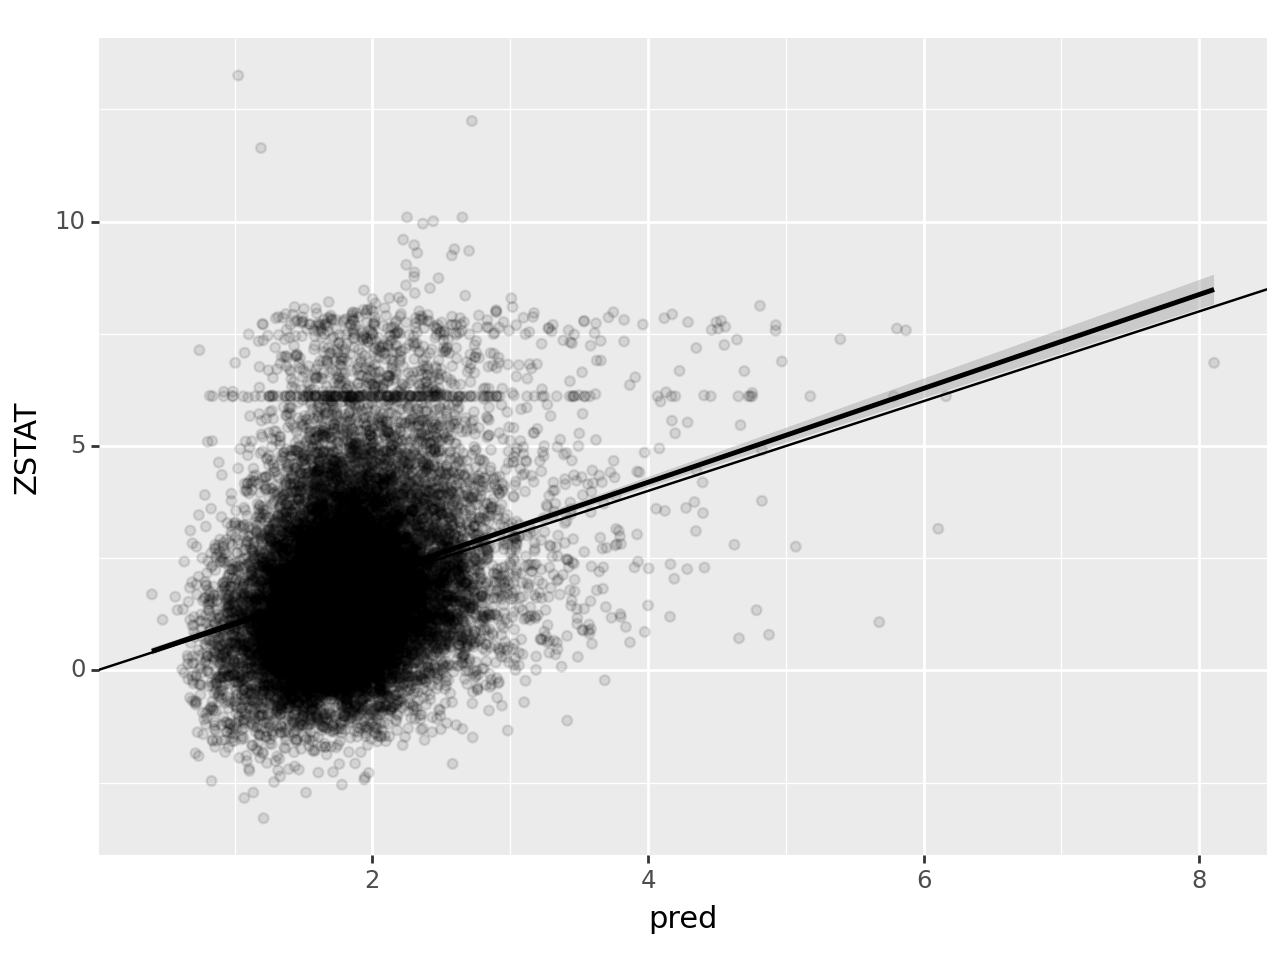

<Figure Size: (640 x 480)>

In [34]:
scatter(df, "pred", "ZSTAT", "pred", "ZSTAT", color = None, smooth=True)

In [42]:
#plot the r score
def plot_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        "r2_null": np.array(r2_null),
        "r2_full": np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=["r2_null", "r2_full"], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()
    return p1, p2

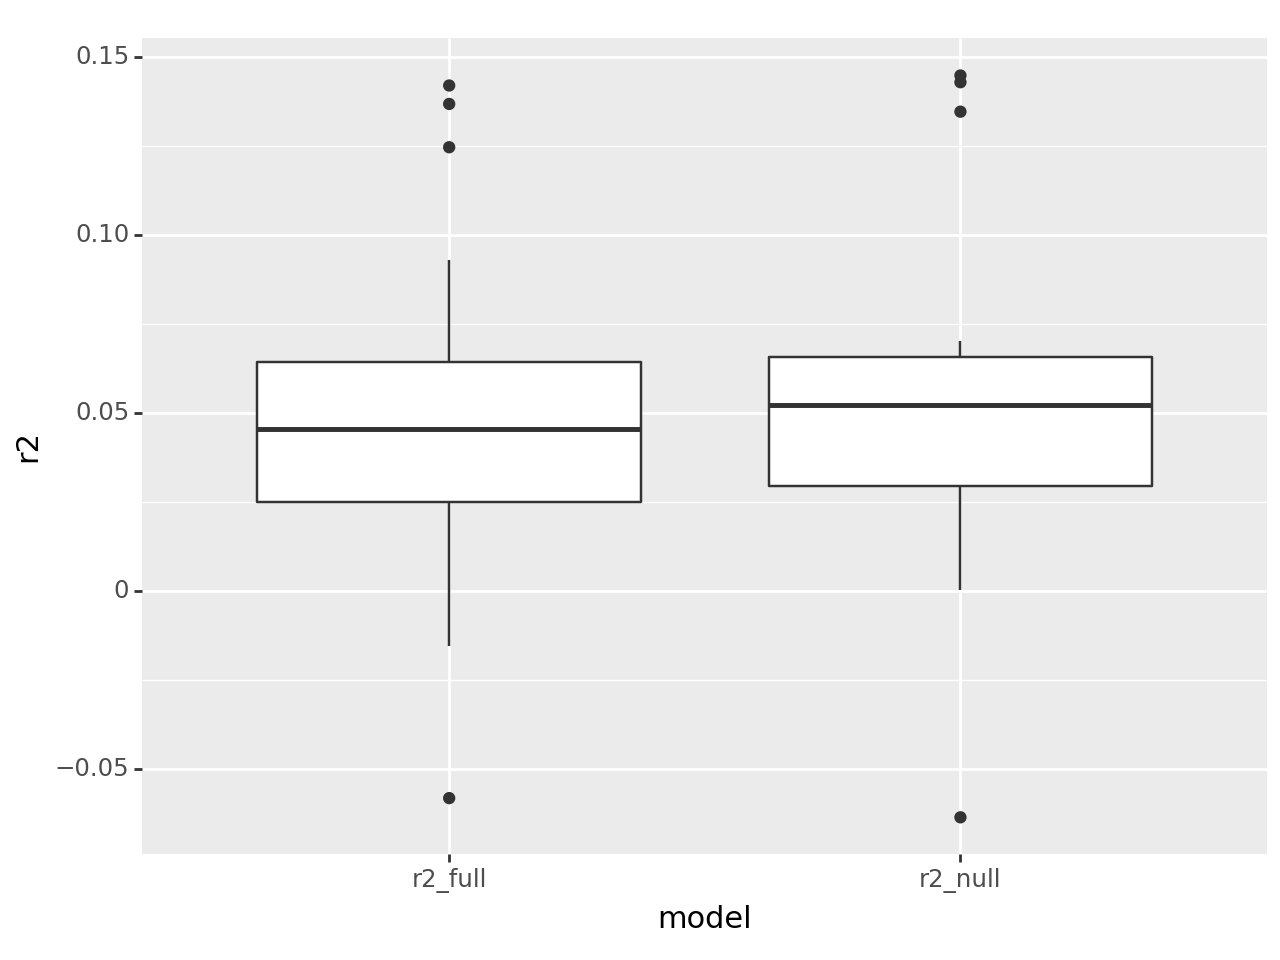

/home/niklas/Documents/TUM/5-WS2324/SysGen/Project/repo/notebooks/venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 6'. Pick better value with 'binwidth'.


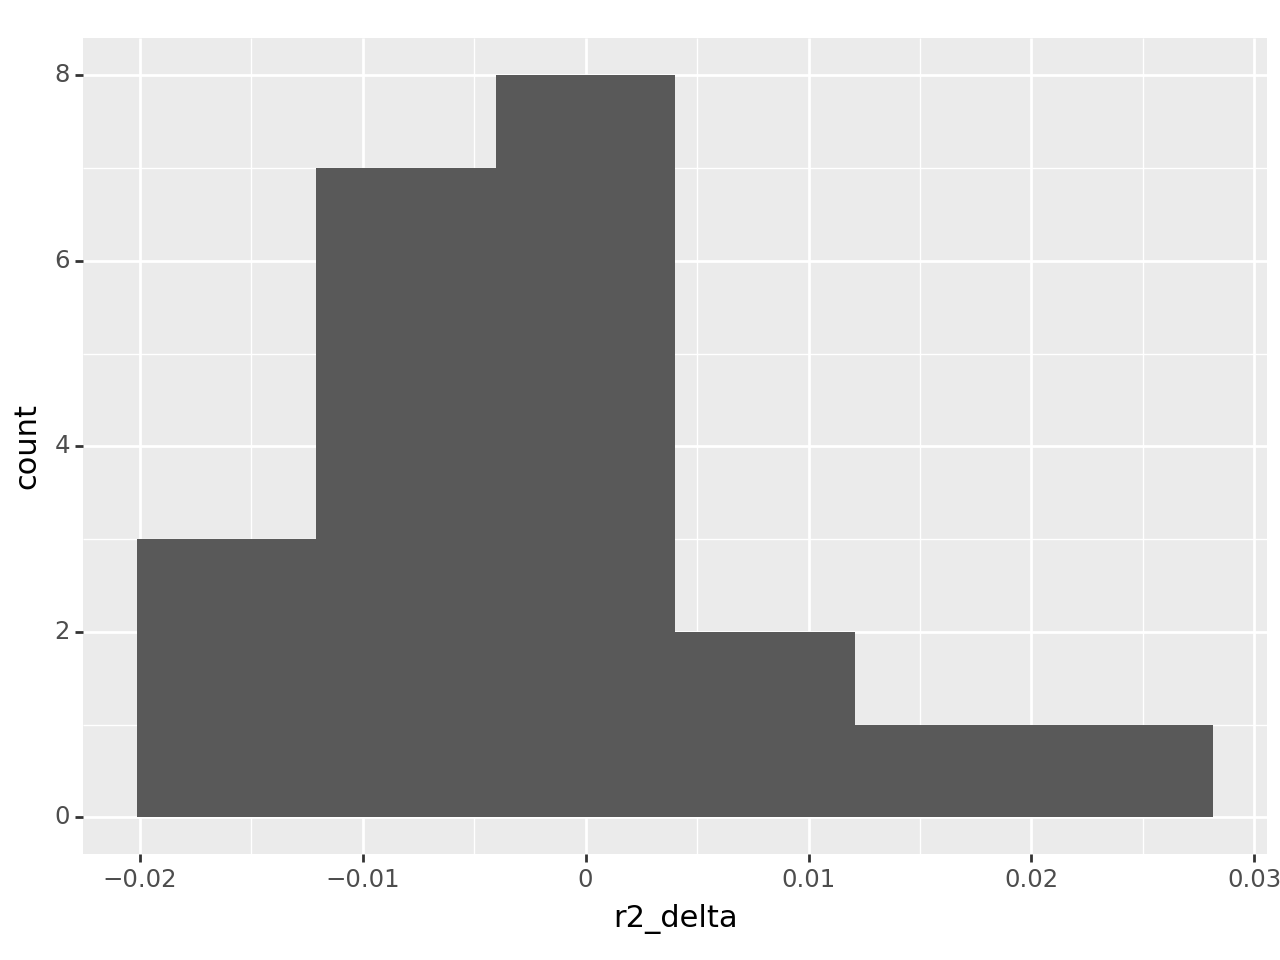

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [43]:
plot_r2(df)

## Old code

In [16]:
X = merged_data.iloc[:, 1:257]  # Columns 1 to 256 are the embedding features
y = merged_data['ZSTAT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'merged_data' is not defined

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:
# Predictions
predictions = model.predict(X_test)
predictions

In [ ]:
# Evaluate Model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

In [ ]:
# Perform PCA
pca = PCA(n_components=10)  # Set the desired number of principal components
principal_components = pca.fit_transform(X)

In [ ]:
# Create DataFrame with Principal Components
pc_columns = [f'PC{i}' for i in range(1, pca.n_components_ + 1)]
pc_df = pd.DataFrame(data=principal_components, columns=pc_columns)
pc_df

In [ ]:
# Concatenate PCA components with original data
merged_data_pca = pd.concat([pc_df, y], axis=1)

# Split Data
X_pca = merged_data_pca.iloc[:, :-2]  # Exclude GENE and ZSTAT columns
y_pca = merged_data_pca['ZSTAT']
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [ ]:
# Train Linear Regression Model on PCA components
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train_pca)

In [ ]:
# Predictions using PCA components
predictions_pca = model_pca.predict(X_test_pca)
predictions_pca

In [ ]:
# Evaluate Model with PCA
mse_pca = mean_squared_error(y_test_pca, predictions_pca)
r2_pca = r2_score(y_test_pca, predictions_pca)

print(f'Mean Squared Error with PCA: {mse_pca}')
print(f'R2 Score with PCA: {r2_pca}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Split Data
X_train, X_test = train_test_split(X_standardized, test_size=0.2, random_state=42)

In [ ]:
# PyTorch Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, input_size)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x

# Train Autoencoder
def train_autoencoder(model, criterion, optimizer, data, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

# Create PyTorch DataLoader
train_data = torch.Tensor(X_train)
test_data = torch.Tensor(X_test)

# Parameters
input_size = X_train.shape[1]
encoding_dim = 64

# Initialize Autoencoder
autoencoder = Autoencoder(input_size, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [ ]:
# Train Autoencoder
train_autoencoder(autoencoder, criterion, optimizer, train_data, num_epochs=500)

In [ ]:
# Evaluate Autoencoder
autoencoder.eval()
encoded_data = autoencoder.encoder(test_data).detach().numpy()

In [ ]:
# PCA
pca = PCA(n_components=encoding_dim)
pca.fit(X_train)
pca_data = pca.transform(X_test)

# Compare Autoencoder and PCA
mse_autoencoder = mean_squared_error(test_data.numpy(), autoencoder(test_data).detach().numpy())
mse_pca = mean_squared_error(X_test, pca.inverse_transform(pca_data))

print(f'Mean Squared Error for Autoencoder: {mse_autoencoder}')
print(f'Mean Squared Error for PCA: {mse_pca}')